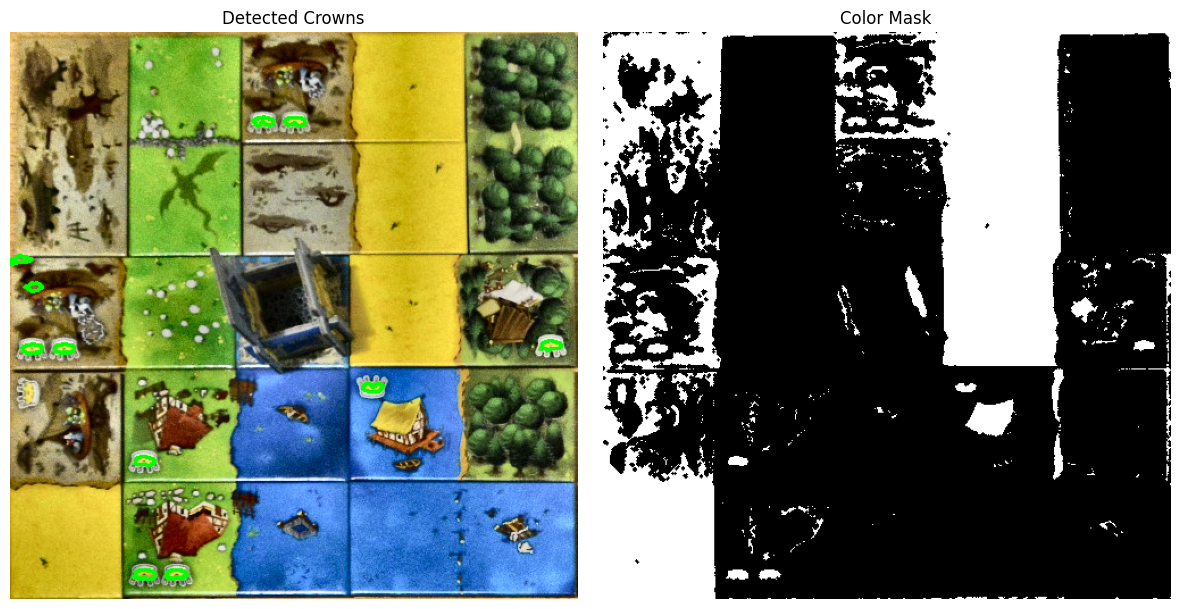

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# Directory with your 74 images (change this to your actual path)
image_dir = "boards.jpg/"  # Example path
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.jpg', '.png'))]


# Load the crown template and extract its contour (adjust this to your actual crown template path)
# For now we simulate an empty placeholder until an actual crown template is provided
crown_template_contour = None  # Will need to be set based on a sample image

def preprocess_image(img):
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # CLAHE on L-channel
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    img_lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(img_lab_clahe, cv2.COLOR_LAB2BGR)

    # Convert enhanced image to both color spaces
    img_lab = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2LAB)
    img_hsv = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2HSV)

    return img_clahe, img_lab, img_hsv


def color_thresholding(img_lab, img_hsv):
    # HSV thresholds for yellow/gold
    hsv_low = np.array([20, 100, 100])
    hsv_high = np.array([30, 255, 255])
    mask_hsv = cv2.inRange(img_hsv, hsv_low, hsv_high)

    # LAB thresholds for gold
    lab_low = np.array([50, 0, 150])
    lab_high = np.array([255, 50, 255])
    mask_lab = cv2.inRange(img_lab, lab_low, lab_high)

    # Combine both masks
    return cv2.bitwise_or(mask_hsv, mask_lab)

def morphological_cleanup(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

def detect_crowns_in_image(img_path):
    img = cv2.imread(img_path)
    img, img_lab, img_hsv = preprocess_image(img)
    mask = color_thresholding(img_lab, img_hsv)
    mask_clean = morphological_cleanup(mask)

    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    detected_crowns = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 58 or area > 130:
            continue

        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area > 0 else 0

        if solidity > 0.7:
            # Edge-based shape verification (placeholder logic)
            match = 0.05  # Simulated score, replace when crown_template_contour is available
            if match < 0.1:
                detected_crowns.append(cnt)

    return img, mask_clean, detected_crowns

# Run on one image to demonstrate
if image_paths:
    sample_img_path = image_paths[13]
    img, mask, crowns = detect_crowns_in_image(sample_img_path)

    # Draw detected crowns on the image
    output = img.copy()
    cv2.drawContours(output, crowns, -1, (0, 255, 0), 2)

    # Convert to RGB for display in matplotlib
    output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    mask_rgb = cv2.cvtColor(cv2.merge([mask, mask, mask]), cv2.COLOR_BGR2RGB)
    

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Detected Crowns")
    plt.imshow(output_rgb)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Color Mask")
    plt.imshow(mask_rgb)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No images found in the directory.")
    
